# 高次元行列での固有対追跡デモンストレーション

このノートブックでは、次元 20 の行列族に対して固有対追跡を行い、
単純な並び替え補正と Ogita-Aishima 法の性能を比較します。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from time import time
from eigenpairflow import eigenpairtrack
from eigenpairflow.correction import ogita_aishima_refinement

## 問題設定

2 つのランダムな対称行列 $A_0, A_1$ を線形補間して $A(t)$ を構成します。
固有値は $t=0$ で昇順，$t=1$ で降順になっており，途中で複雑に交差します。

In [2]:
n = 20
np.random.seed(0)
Q0, _ = np.linalg.qr(np.random.randn(n, n))
Q1, _ = np.linalg.qr(np.random.randn(n, n))

# 固有値を反転させて交差を作る
eigvals0 = np.linspace(1, n, n)
eigvals1 = eigvals0[::-1]

A0 = Q0 @ np.diag(eigvals0) @ Q0.T
A1 = Q1 @ np.diag(eigvals1) @ Q1.T

def A_func(t):
    """補間された対称行列 A(t) を返す。"""
    return (1 - t) * A0 + t * A1

def dA_func(t):
    """A(t) の t に関する導関数を返す。"""
    return A1 - A0

t_eval = np.linspace(0, 1, 20)


## 補正なしで追跡

In [3]:
start = time()
results_none = eigenpairtrack(
    A_func,
    dA_func,
    (0.0, 1.0),
    t_eval,
    correction_method=None,
)
elapsed_none = time() - start


## 並び替えマッチング補正

In [4]:
start = time()
results_match = eigenpairtrack(
    A_func,
    dA_func,
    (0.0, 1.0),
    t_eval,
    correction_method="matching",
)
elapsed_match = time() - start


## Ogita-Aishima 補正

In [5]:
start = time()
results_ogita = eigenpairtrack(
    A_func,
    dA_func,
    (0.0, 1.0),
    t_eval,
    correction_method="ogita_aishima",
)
elapsed_ogita = time() - start


## Ogita-Aishima のみで追跡（ODE ソルバーなし）

In [6]:
start = time()

def track_with_ogita_only(A_func, t_eval):
    """ODE ソルバーを使わずに荻田-青島法だけで固有対を追跡する。"""
    Qs = []
    Ds = []
    t0 = t_eval[0]
    A0 = A_func(t0)
    eigvals0, Q0 = np.linalg.eigh(A0)
    idx = np.argsort(eigvals0)
    Q_prev = Q0[:, idx]
    D_prev = np.diag(eigvals0[idx])
    Qs.append(Q_prev)
    Ds.append(D_prev)
    for t in t_eval[1:]:
        A_t = A_func(t)
        Q_prev, D_prev = ogita_aishima_refinement(A_t, Q_prev)
        Qs.append(Q_prev)
        Ds.append(D_prev)
    return Qs, Ds

Qs_ogita_only, Ds_ogita_only = track_with_ogita_only(A_func, t_eval)
elapsed_ogita_only = time() - start


## 誤差と計算時間の比較

補正なし: 20.52s, 最終誤差 8.97e-11
並び替えマッチング: 20.47s, 最終誤差 1.31e-13
Ogita-Aishima: 22.42s, 最終誤差 5.54e-14
Ogitaのみ: 0.04s, 最終誤差 2.51e+00


/root/.pyenv/versions/3.11.12/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 35036 (\N{CJK UNIFIED IDEOGRAPH-88DC}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/root/.pyenv/versions/3.11.12/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27491 (\N{CJK UNIFIED IDEOGRAPH-6B63}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/root/.pyenv/versions/3.11.12/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12394 (\N{HIRAGANA LETTER NA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/root/.pyenv/versions/3.11.12/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12375 (\N{HIRAGANA LETTER SI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/root/.pyenv/versions/3.11.12/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12510 

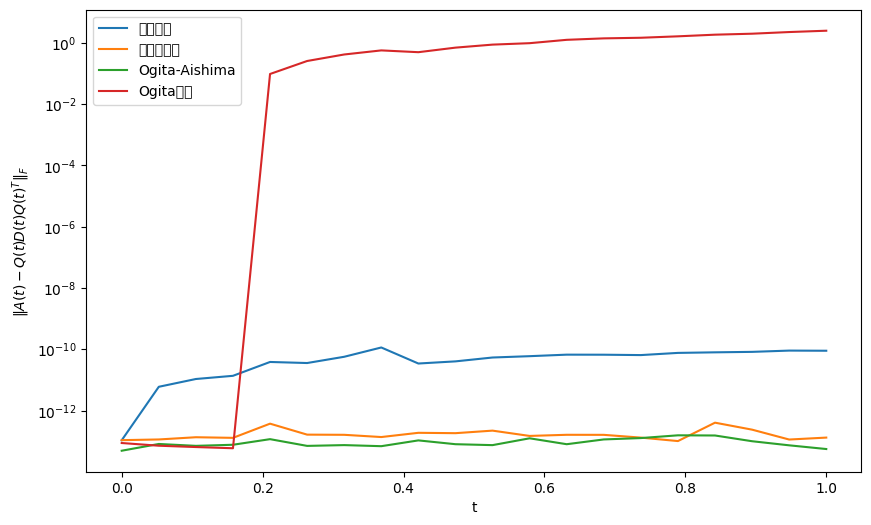

In [7]:
norm_errors_ogita_only = []
for t, Q, D in zip(t_eval, Qs_ogita_only, Ds_ogita_only):
    A_t = A_func(t)
    norm_errors_ogita_only.append(np.linalg.norm(A_t - Q @ D @ Q.T, 'fro'))

print(f"補正なし: {elapsed_none:.2f}s, 最終誤差 {results_none.norm_errors[-1]:.2e}")
print(f"並び替えマッチング: {elapsed_match:.2f}s, 最終誤差 {results_match.norm_errors[-1]:.2e}")
print(f"Ogita-Aishima: {elapsed_ogita:.2f}s, 最終誤差 {results_ogita.norm_errors[-1]:.2e}")
print(f"Ogitaのみ: {elapsed_ogita_only:.2f}s, 最終誤差 {norm_errors_ogita_only[-1]:.2e}")

plt.figure(figsize=(10,6))
plt.plot(results_none.t_eval, results_none.norm_errors, label="補正なし")
plt.plot(results_match.t_eval, results_match.norm_errors, label="マッチング")
plt.plot(results_ogita.t_eval, results_ogita.norm_errors, label="Ogita-Aishima")
plt.plot(t_eval, norm_errors_ogita_only, label="Ogitaのみ")
plt.yscale("log")
plt.xlabel("t")
plt.ylabel(r"$\|A(t) - Q(t)D(t)Q(t)^T\|_F$")
plt.legend()
plt.show()
